In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

project_path = '/content/drive/MyDrive/stock_price'
os.chdir(project_path)

# Verify
!ls

 alpha_earnings_calls.csv	 best_model.pth
 alpha_economic_indicators.csv	 data
 alpha_stock_prices.csv		 merged_news_stock.csv
 alpha_ticker_news.csv		'merged_news_stock(finbert).csv'
 alpha_topic_news.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import os
from sklearn.model_selection import train_test_split

check data

In [24]:
print(df[['close', 'finbert_score']].isnull().sum())

close            0
finbert_score    0
dtype: int64


In [30]:
print(df['finbert_score'].describe())

count    16473.000000
mean        -0.290295
std          0.790085
min         -0.977052
25%         -0.916304
50%         -0.765430
75%          0.742538
max          0.961266
Name: finbert_score, dtype: float64


In [32]:
print(data['close_scaled'].describe())

count    481.000000
mean       0.516423
std        0.222204
min        0.000000
25%        0.366300
50%        0.489796
75%        0.627420
max        1.000000
Name: close_scaled, dtype: float64


In [34]:
print("NaN values in original DataFrame:")
print(df[['close', 'finbert_score']].isnull().sum())

NaN values in original DataFrame:
close            0
finbert_score    0
dtype: int64


only use close price to predict

Epoch [1/20], Training Loss: 0.0443
Epoch [1/20], Validation Loss: 0.0134
Epoch [2/20], Training Loss: 0.0057
Epoch [2/20], Validation Loss: 0.0113
Epoch [3/20], Training Loss: 0.0044
Epoch [3/20], Validation Loss: 0.0086
Epoch [4/20], Training Loss: 0.0035
Epoch [4/20], Validation Loss: 0.0075
Epoch [5/20], Training Loss: 0.0031
Epoch [5/20], Validation Loss: 0.0069
Epoch [6/20], Training Loss: 0.0028
Epoch [6/20], Validation Loss: 0.0064
Epoch [7/20], Training Loss: 0.0026
Epoch [7/20], Validation Loss: 0.0063
Epoch [8/20], Training Loss: 0.0024
Epoch [8/20], Validation Loss: 0.0050
Epoch [9/20], Training Loss: 0.0023
Epoch [9/20], Validation Loss: 0.0049
Epoch [10/20], Training Loss: 0.0022
Epoch [10/20], Validation Loss: 0.0046
Epoch [11/20], Training Loss: 0.0021
Epoch [11/20], Validation Loss: 0.0042
Epoch [12/20], Training Loss: 0.0020
Epoch [12/20], Validation Loss: 0.0041
Epoch [13/20], Training Loss: 0.0019
Epoch [13/20], Validation Loss: 0.0043
Epoch [14/20], Training Loss: 

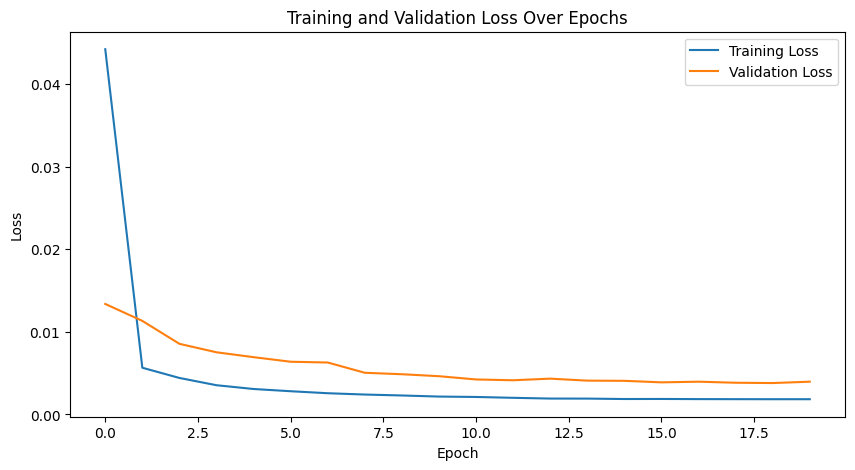

Test Loss: 0.0021


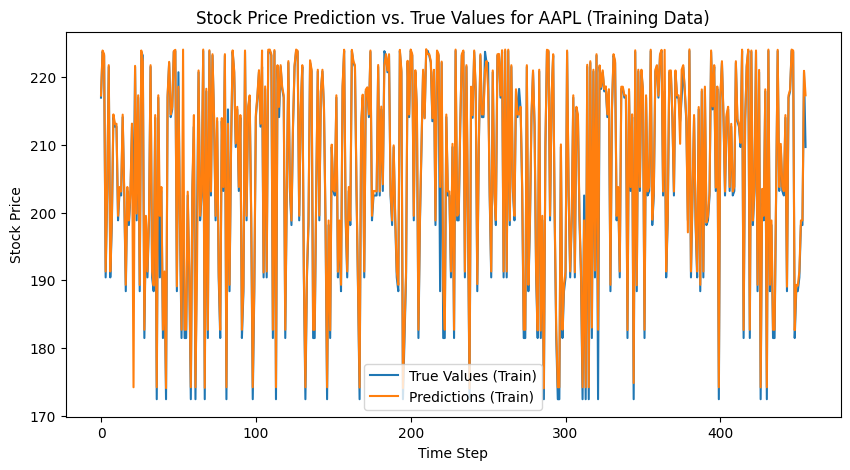

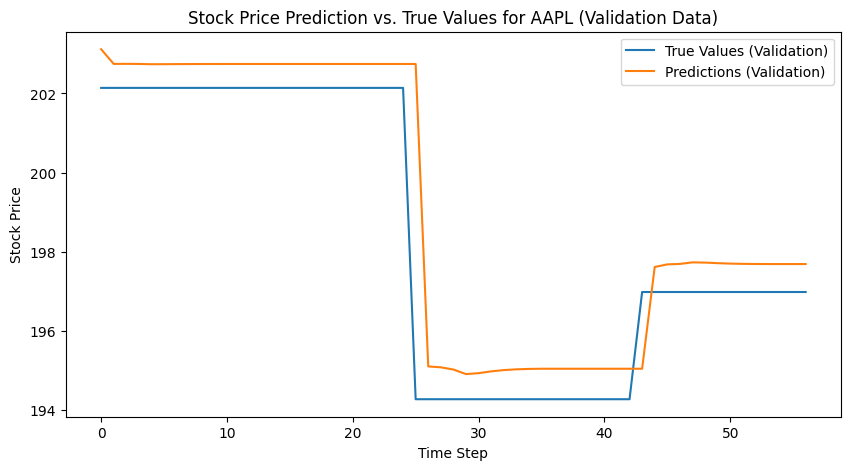

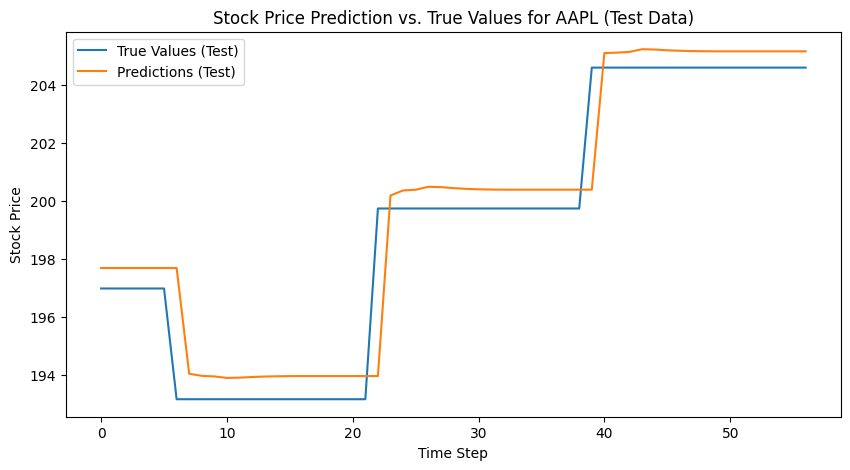

In [20]:
# only use close price to predict


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import os
from sklearn.model_selection import train_test_split

# Load stock price data
df = pd.read_csv("merged_news_stock(finbert).csv")

# 1. Separate data by company
grouped = df.groupby('ticker')
company_data = {company: group.sort_values('date').copy() for company, group in grouped}

# Define sequence length (window size)
sequence_length = 10


# 2. Preprocessing and creating sequences
processed_data = {}
scalers = {}

for company, data in company_data.items():
    scaler = MinMaxScaler()
    data['close_scaled'] = scaler.fit_transform(data[['close']])
    scalers[company] = scaler

    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data['close_scaled'].iloc[i:i + sequence_length].values)
        targets.append(data['close_scaled'].iloc[i + sequence_length])

    processed_data[company] = (np.array(sequences), np.array(targets))

# 3. Create company ID mapping
unique_companies = list(company_data.keys())
company_to_id = {company: i for i, company in enumerate(unique_companies)}
num_companies = len(unique_companies)

# 4. Create PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, sequences, targets, company_ids):
        self.sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)
        self.company_ids = torch.tensor(company_ids, dtype=torch.long).unsqueeze(-1)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx], self.company_ids[idx]

train_datasets = {}
val_datasets = {}
test_datasets = {}

train_sequences_all = []
train_targets_all = []
train_company_ids_all = []
val_sequences_all = []
val_targets_all = []
val_company_ids_all = []
test_sequences_all = []
test_targets_all = []
test_company_ids_all = []

train_size = 0.8
val_size = 0.1

for company, (sequences, targets) in processed_data.items():
    n = len(sequences)
    train_idx = int(n * train_size)
    val_idx = int(n * (train_size + val_size))

    train_sequences = sequences[:train_idx]
    train_targets = targets[:train_idx]
    val_sequences = sequences[train_idx:val_idx]
    val_targets = targets[train_idx:val_idx]
    test_sequences = sequences[val_idx:]
    test_targets = targets[val_idx:]

    company_id = company_to_id[company]
    train_company_ids = np.full(len(train_sequences), company_id)
    val_company_ids = np.full(len(val_sequences), company_id)
    test_company_ids = np.full(len(test_sequences), company_id)

    train_sequences_all.extend(train_sequences)
    train_targets_all.extend(train_targets)
    train_company_ids_all.extend(train_company_ids)
    val_sequences_all.extend(val_sequences)
    val_targets_all.extend(val_targets)
    val_company_ids_all.extend(val_company_ids)
    test_sequences_all.extend(test_sequences)
    test_targets_all.extend(test_targets)
    test_company_ids_all.extend(test_company_ids)

train_dataset = StockDataset(train_sequences_all, train_targets_all, train_company_ids_all)
val_dataset = StockDataset(val_sequences_all, val_targets_all, val_company_ids_all)
test_dataset = StockDataset(test_sequences_all, test_targets_all, test_company_ids_all)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Define the Shared Model with Company Embedding
class SharedStockModel(nn.Module):
    def __init__(self, num_companies, embedding_dim, sequence_length, hidden_units):
        super(SharedStockModel, self).__init__()
        self.embedding = nn.Embedding(num_companies, embedding_dim)
        self.lstm = nn.LSTM(input_size=1 + embedding_dim, hidden_size=hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x, company_ids):
        # x shape: (batch_size, sequence_length, 1)
        # company_ids shape: (batch_size, 1)

        embedded_companies = self.embedding(company_ids).unsqueeze(1).repeat(1, x.size(1), 1)
        # embedded_companies shape: (batch_size, sequence_length, embedding_dim)

        combined_input = torch.cat((x, embedded_companies), dim=-1)
        # combined_input shape: (batch_size, sequence_length, 1 + embedding_dim)

        out, _ = self.lstm(combined_input)
        # out shape: (batch_size, sequence_length, hidden_units)

        # Predict the last time step's output
        predictions = self.linear(out[:, -1, :])
        return predictions


# 6. Instantiate the model, loss function, and optimizer
embedding_dim = 10
hidden_units = 50
model = SharedStockModel(num_companies, embedding_dim, sequence_length, hidden_units)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# 7. Train the model
epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for sequences, targets, company_ids in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)  # Squeeze the company_ids

        optimizer.zero_grad()
        predictions = model(sequences, company_ids)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for sequences, targets, company_ids in val_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            company_ids = company_ids.to(device).squeeze(1)

            predictions = model(sequences, company_ids)
            loss = criterion(predictions, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 8. Evaluate the model on the test set
model.eval()
test_loss = 0
all_predictions_test = []
all_targets_test = []
all_original_companies_test = []

with torch.no_grad():
    for sequences, targets, company_ids in test_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

        all_predictions_test.extend(predictions.cpu().numpy())
        all_targets_test.extend(targets.cpu().numpy())
        all_original_companies_test.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')


# Inverse transform function
def inverse_transform_predictions(predictions_scaled, targets_scaled, company_name, scalers, original_companies):
    company_scaler = scalers[company_name]
    company_indices = [i for i, company in enumerate(original_companies) if company == company_name]
    company_predictions_scaled = np.array([predictions_scaled[i] for i in company_indices])
    company_targets_scaled = np.array([targets_scaled[i] for i in company_indices])
    company_predictions_original = company_scaler.inverse_transform(company_predictions_scaled)
    company_targets_original = company_scaler.inverse_transform(company_targets_scaled)
    return company_predictions_original, company_targets_original

# Get predictions and true values for the validation set
model.eval()
all_predictions_val = []
all_targets_val = []
all_original_companies_val = []

with torch.no_grad():
    for sequences, targets, company_ids in val_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)

        all_predictions_val.extend(predictions.cpu().numpy())
        all_targets_val.extend(targets.cpu().numpy())
        all_original_companies_val.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

# Get predictions and true values for the training set
model.eval()
all_predictions_train = []
all_targets_train = []
all_original_companies_train = []

with torch.no_grad():
    for sequences, targets, company_ids in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)

        all_predictions_train.extend(predictions.cpu().numpy())
        all_targets_train.extend(targets.cpu().numpy())
        all_original_companies_train.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

# 9. Inverse transform and plot for the first company on each dataset
first_company = unique_companies[0]

# Plotting for the Training Dataset
train_predictions_original, train_targets_original = inverse_transform_predictions(
    all_predictions_train, all_targets_train, first_company, scalers, all_original_companies_train
)
plt.figure(figsize=(10, 5))
plt.plot(train_targets_original, label='True Values (Train)')
plt.plot(train_predictions_original, label='Predictions (Train)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Training Data)')
plt.legend()
plt.show()

# Plotting for the Validation Dataset
val_predictions_original, val_targets_original = inverse_transform_predictions(
    all_predictions_val, all_targets_val, first_company, scalers, all_original_companies_val
)
plt.figure(figsize=(10, 5))
plt.plot(val_targets_original, label='True Values (Validation)')
plt.plot(val_predictions_original, label='Predictions (Validation)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Validation Data)')
plt.legend()
plt.show()

# Plotting for the Test Dataset
test_predictions_original, test_targets_original = inverse_transform_predictions(
    all_predictions_test, all_targets_test, first_company, scalers, all_original_companies_test
)
plt.figure(figsize=(10, 5))
plt.plot(test_targets_original, label='True Values (Test)')
plt.plot(test_predictions_original, label='Predictions (Test)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Test Data)')
plt.legend()
plt.show()

# use close + finbert_socre to predict

In [46]:
# use close + finbert_socre to predict

# Load stock price data
df = pd.read_csv("merged_news_stock(finbert).csv")

# Define the features to use
features = ['close', 'finbert_socre']
target_feature = 'close'

# 1. Separate data by company
grouped = df.groupby('ticker')
company_data = {company: group.sort_values('date').copy() for company, group in grouped}

# Define sequence length (window size)
sequence_length = 10

# 2. Preprocessing and creating sequences
processed_data = {}
scalers = {}

for company, data in company_data.items():
    scaler = MinMaxScaler()
    data['close_scaled'] = scaler.fit_transform(data[['close']])
    data['finbert_score_scaled'] = scaler.fit_transform(data[['finbert_score']])
    scalers[company] = scaler

    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        close_seq = data['close_scaled'].iloc[i:i + sequence_length].values
        finbert_seq = data['finbert_score'].iloc[i:i + sequence_length].values
        sequence = np.stack([close_seq, finbert_seq], axis=-1)
        target = data['close_scaled'].iloc[i + sequence_length]
        # print(f"Company: {company}, Index: {i}")
        # print("Sequence (Close):\n", close_seq)
        # print("Sequence (FinBERT):\n", finbert_seq)
        # print("Combined Sequence:\n", sequence)
        # print("Target (Close Scaled):\n", target)
        if np.isnan(sequence).any() or np.isnan(target):
            print("NaN found in sequence or target!")
        sequences.append(sequence)
        targets.append(target)

    processed_data[company] = (np.array(sequences), np.array(targets))



# 3. Create company ID mapping
unique_companies = list(company_data.keys())
company_to_id = {company: i for i, company in enumerate(unique_companies)}
num_companies = len(unique_companies)

# 4. Create PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, sequences, targets, company_ids):
        #self.sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
        self.sequences = torch.tensor(sequences, dtype=torch.float32)  # Shape: (seq_len, num_features)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)
        self.company_ids = torch.tensor(company_ids, dtype=torch.long).unsqueeze(-1)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx], self.company_ids[idx]

train_datasets = {}
val_datasets = {}
test_datasets = {}

train_sequences_all = []
train_targets_all = []
train_company_ids_all = []
val_sequences_all = []
val_targets_all = []
val_company_ids_all = []
test_sequences_all = []
test_targets_all = []
test_company_ids_all = []

train_size = 0.8
val_size = 0.1

for company, (sequences, targets) in processed_data.items():
    n = len(sequences)
    train_idx = int(n * train_size)
    val_idx = int(n * (train_size + val_size))

    train_sequences = sequences[:train_idx]
    train_targets = targets[:train_idx]
    val_sequences = sequences[train_idx:val_idx]
    val_targets = targets[train_idx:val_idx]
    test_sequences = sequences[val_idx:]
    test_targets = targets[val_idx:]

    company_id = company_to_id[company]
    train_company_ids = np.full(len(train_sequences), company_id)
    val_company_ids = np.full(len(val_sequences), company_id)
    test_company_ids = np.full(len(test_sequences), company_id)

    train_sequences_all.extend(train_sequences)
    train_targets_all.extend(train_targets)
    train_company_ids_all.extend(train_company_ids)
    val_sequences_all.extend(val_sequences)
    val_targets_all.extend(val_targets)
    val_company_ids_all.extend(val_company_ids)
    test_sequences_all.extend(test_sequences)
    test_targets_all.extend(test_targets)
    test_company_ids_all.extend(test_company_ids)

train_dataset = StockDataset(train_sequences_all, train_targets_all, train_company_ids_all)
val_dataset = StockDataset(val_sequences_all, val_targets_all, val_company_ids_all)
test_dataset = StockDataset(test_sequences_all, test_targets_all, test_company_ids_all)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Define the Shared Model with Company Embedding
class SharedStockModel(nn.Module):
    def __init__(self, num_companies, embedding_dim, sequence_length, hidden_units):
        super(SharedStockModel, self).__init__()
        self.embedding = nn.Embedding(num_companies, embedding_dim)
        self.lstm = nn.LSTM(input_size=1 + embedding_dim, hidden_size=hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x, company_ids):
        # x shape: (batch_size, sequence_length, 1)
        # company_ids shape: (batch_size, 1)

        embedded_companies = self.embedding(company_ids).unsqueeze(1).repeat(1, x.size(1), 1)
        # embedded_companies shape: (batch_size, sequence_length, embedding_dim)

        combined_input = torch.cat((x, embedded_companies), dim=-1)
        # combined_input shape: (batch_size, sequence_length, 1 + embedding_dim)

        out, _ = self.lstm(combined_input)
        # out shape: (batch_size, sequence_length, hidden_units)

        # Predict the last time step's output
        predictions = self.linear(out[:, -1, :])
        return predictions


# 6. Instantiate the model, loss function, and optimizer
embedding_dim = 10
hidden_units = 50
model = SharedStockModel(num_companies, embedding_dim, sequence_length, hidden_units)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# 7. Train the model
epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for sequences, targets, company_ids in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)  # Squeeze the company_ids

        optimizer.zero_grad()
        predictions = model(sequences, company_ids)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for sequences, targets, company_ids in val_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            company_ids = company_ids.to(device).squeeze(1)

            predictions = model(sequences, company_ids)
            loss = criterion(predictions, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 8. Evaluate the model on the test set
model.eval()
test_loss = 0
all_predictions_test = []
all_targets_test = []
all_original_companies_test = []

with torch.no_grad():
    for sequences, targets, company_ids in test_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

        all_predictions_test.extend(predictions.cpu().numpy())
        all_targets_test.extend(targets.cpu().numpy())
        all_original_companies_test.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')


# Inverse transform function
def inverse_transform_predictions(predictions_scaled, targets_scaled, company_name, scalers, original_companies):
    company_scaler = scalers[company_name]
    company_indices = [i for i, company in enumerate(original_companies) if company == company_name]
    company_predictions_scaled = np.array([predictions_scaled[i] for i in company_indices])
    company_targets_scaled = np.array([targets_scaled[i] for i in company_indices])
    company_predictions_original = company_scaler.inverse_transform(company_predictions_scaled)
    company_targets_original = company_scaler.inverse_transform(company_targets_scaled)
    return company_predictions_original, company_targets_original

# Get predictions and true values for the validation set
model.eval()
all_predictions_val = []
all_targets_val = []
all_original_companies_val = []

with torch.no_grad():
    for sequences, targets, company_ids in val_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)

        all_predictions_val.extend(predictions.cpu().numpy())
        all_targets_val.extend(targets.cpu().numpy())
        all_original_companies_val.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

# Get predictions and true values for the training set
model.eval()
all_predictions_train = []
all_targets_train = []
all_original_companies_train = []

with torch.no_grad():
    for sequences, targets, company_ids in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        company_ids = company_ids.to(device).squeeze(1)

        predictions = model(sequences, company_ids)

        all_predictions_train.extend(predictions.cpu().numpy())
        all_targets_train.extend(targets.cpu().numpy())
        all_original_companies_train.extend([unique_companies[i] for i in company_ids.cpu().numpy()])

# 9. Inverse transform and plot for the first company on each dataset
first_company = unique_companies[0]

# Plotting for the Training Dataset
train_predictions_original, train_targets_original = inverse_transform_predictions(
    all_predictions_train, all_targets_train, first_company, scalers, all_original_companies_train
)
plt.figure(figsize=(10, 5))
plt.plot(train_targets_original, label='True Values (Train)')
plt.plot(train_predictions_original, label='Predictions (Train)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Training Data)')
plt.legend()
plt.show()

# Plotting for the Validation Dataset
val_predictions_original, val_targets_original = inverse_transform_predictions(
    all_predictions_val, all_targets_val, first_company, scalers, all_original_companies_val
)
plt.figure(figsize=(10, 5))
plt.plot(val_targets_original, label='True Values (Validation)')
plt.plot(val_predictions_original, label='Predictions (Validation)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Validation Data)')
plt.legend()
plt.show()

# Plotting for the Test Dataset
test_predictions_original, test_targets_original = inverse_transform_predictions(
    all_predictions_test, all_targets_test, first_company, scalers, all_original_companies_test
)
plt.figure(figsize=(10, 5))
plt.plot(test_targets_original, label='True Values (Test)')
plt.plot(test_predictions_original, label='Predictions (Test)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction vs. True Values for {first_company} (Test Data)')
plt.legend()
plt.show()








RuntimeError: input.size(-1) must be equal to input_size. Expected 11, got 12